In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning Analysis

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import joblib

from utils.helper_functions import split_data

In [39]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))

In [40]:
train_df, val_df, test_df = split_data(cancer_df)

In [41]:
train_df.loc[:, numeric_cols] = scaler.transform(train_df[numeric_cols])
val_df.loc[:, numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df.loc[:, numeric_cols] = scaler.transform(test_df[numeric_cols])

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

def create_pipeline(model_args = {}):
    """
    Create a pipeline with the given model.
    """
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.compose import TransformedTargetRegressor

    preprocessor = ColumnTransformer(
            transformers=[
                ('scaler', StandardScaler(), numeric_cols)
            ],
            remainder='passthrough',
            force_int_remainder_cols=False
        )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(**model_args),
            )
    ])
    return pipeline

In [43]:
from utils.helper_functions import plot_regression_results_sklearn, get_features_and_target


model_args = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "random_state": 42
}
model = create_pipeline(model_args)
train_features, train_target = get_features_and_target(train_df)
model.fit(train_features, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['SMOKING_PACK_YEARS',
                                                   'CNA_CHD5', 'CNA_PTCHD2',
                                                   'CNA_VPS13D', 'CNA_UBR4',
                                                   'CNA_HSPG2', 'CNA_ARID1A',
                                                   'CNA_CSMD2', 'CNA_MACF1',
                                                   'CNA_LRRC7', 'CNA_C1orf173',
                                                   'CNA_LPHN2', 'CNA_COL24A1',
                                                   'CNA_LPPR4', 'CNA_COL11A1',
                                                   'CNA_SPAG17', 'CNA_PDE4DIP',
                                                   'CNA_TCHH', 'CNA_HRNR',
                                                   'CNA_FLG', 'CNA_FLG2',
                                                   'CNA_FCRL5', 'CNA_SPTA1',
                                                   'CNA_DUSP27', 'CNA_F5',
                                                   'CNA_TNN', 'CNA_TNR',
                                                   'CNA_PAPPA2', 'CNA_ASTN1',
                                                   'CNA_CACNA1E', ...])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       random_state=42))])

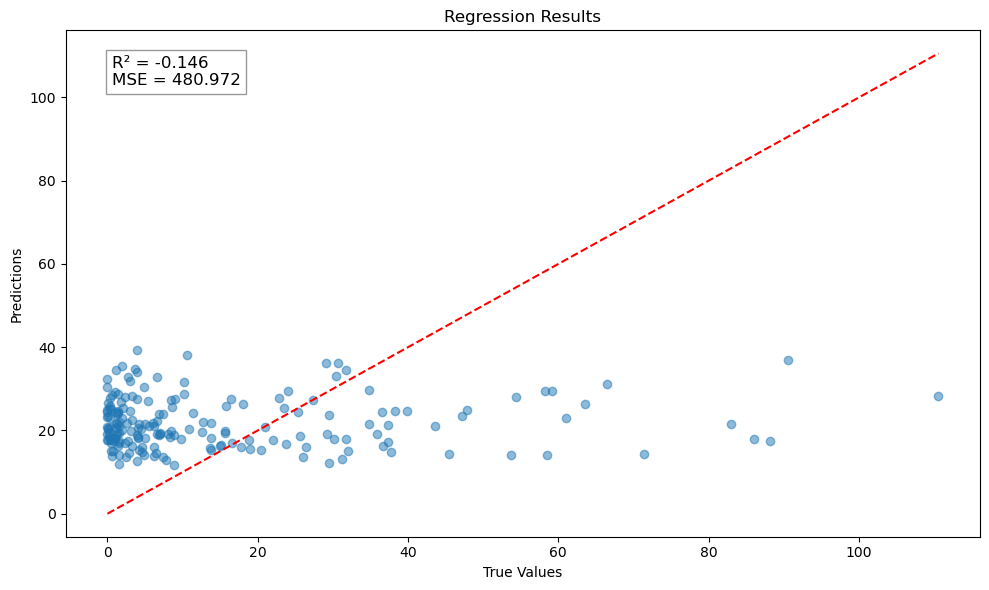

In [44]:
plot_regression_results_sklearn(model, test_df)

In [45]:
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial : optuna.Trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 400)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 40)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 40)
    model = create_pipeline({
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "random_state": 42
        })
    train_features, train_target = get_features_and_target(train_df)
    val_features, val_target = get_features_and_target(val_df)


    model.fit(train_features, train_target)
    mse = mean_squared_error(val_target, model.predict(val_features))
    return  mse


In [46]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="rf_study")
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-18 10:57:04,002] A new study created in memory with name: rf_study


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-04-18 10:57:12,517] Trial 8 finished with value: 688.6166815168536 and parameters: {'n_estimators': 37, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 32}. Best is trial 8 with value: 688.6166815168536.
[I 2025-04-18 10:57:23,914] Trial 0 finished with value: 685.9111662104211 and parameters: {'n_estimators': 190, 'max_depth': 334, 'min_samples_split': 39, 'min_samples_leaf': 40}. Best is trial 0 with value: 685.9111662104211.
[I 2025-04-18 10:57:25,149] Trial 15 finished with value: 692.8102404567393 and parameters: {'n_estimators': 147, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 18}. Best is trial 0 with value: 685.9111662104211.
[I 2025-04-18 10:57:29,367] Trial 4 finished with value: 682.7629572682482 and parameters: {'n_estimators': 272, 'max_depth': 117, 'min_samples_split': 2, 'min_samples_leaf': 38}. Best is trial 4 with value: 682.7629572682482.
[I 2025-04-18 10:57:30,873] Trial 9 finished with value: 685.1848241152987 and parameters: {

In [47]:
best_model = create_pipeline(study.best_trial.params)
train_features, train_target = get_features_and_target(train_df)
best_model.fit(train_features, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['SMOKING_PACK_YEARS',
                                                   'CNA_CHD5', 'CNA_PTCHD2',
                                                   'CNA_VPS13D', 'CNA_UBR4',
                                                   'CNA_HSPG2', 'CNA_ARID1A',
                                                   'CNA_CSMD2', 'CNA_MACF1',
                                                   'CNA_LRRC7', 'CNA_C1orf173',
                                                   'CNA_LPHN2', 'CNA_COL24A1',
                                                   'CNA_LPPR4', 'CNA_COL11A1',
                                                   'CNA_SPAG17', 'CNA_PDE4DIP',
                                                   'CNA_TCHH', 'CNA_HRNR',
                                                   'CNA_FLG', 'CNA_FLG2',
                                                   'CNA_FCRL5', 'CNA_SPTA1',
                                                   'CNA_DUSP27', 'CNA_F5',
                                                   'CNA_TNN', 'CNA_TNR',
                                                   'CNA_PAPPA2', 'CNA_ASTN1',
                                                   'CNA_CACNA1E', ...])])),
                ('regressor',
                 RandomForestRegressor(max_depth=246, min_samples_split=37,
                                       n_estimators=548))])

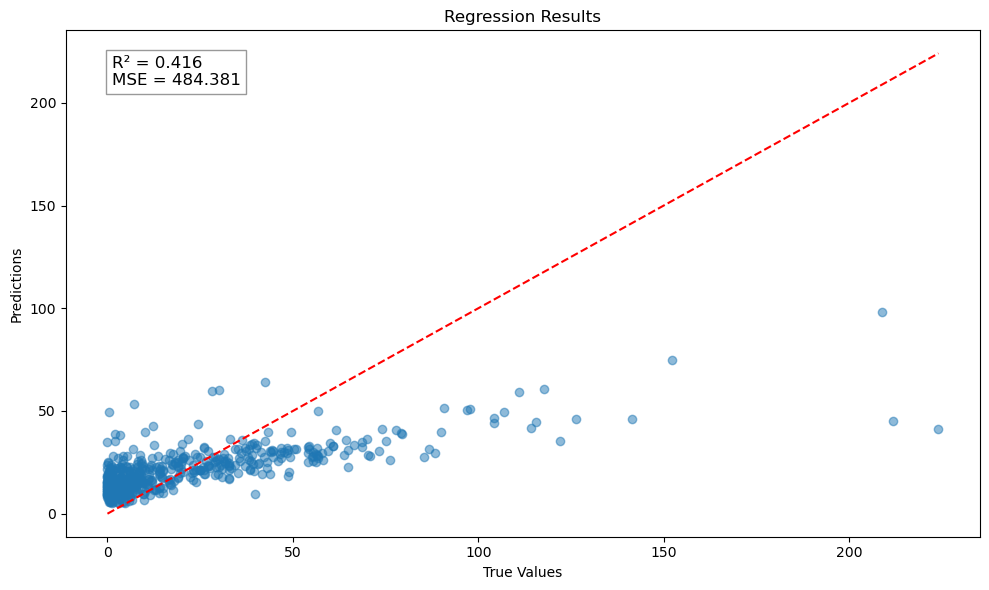

In [48]:
plot_regression_results_sklearn(best_model, train_df)
